## 1. Import Library

In [21]:
# Basic Library
import pandas as pd
import numpy as np
import os

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 2. Import Data

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")

## 3. CNN Modeling

### (1) HP Tuning

In [13]:
train_x = train.iloc[:, 1:-1]
test_x = test.iloc[:, 1:]

train_x = np.array(train_x).reshape(-1, 8, 4, 1)
test_x = np.array(test_x).reshape(-1, 8, 4, 1)

ohe = OneHotEncoder(sparse = False)
train_y = ohe.fit_transform(train[['target']])

In [14]:
def create_model(num_layer, mid_units, num_filters):
    
    model = Sequential()
    model.add(Conv2D(filters=num_filters[0], kernel_size=(2, 2),
                 activation="elu",
                 input_shape=(8, 4, 1)))
    model.add(BatchNormalization())
    #model.add(Dropout(dropout_rate[0]))
    for i in range(1,num_layer):
        model.add(Conv2D(filters=num_filters[i], kernel_size=(2, 2), padding="same", activation="elu"))
        model.add(BatchNormalization())
        #model.add(Dropout(dropout_rate[i+1]))
            
    model.add(GlobalAveragePooling2D())
    model.add(Dense(mid_units, activation='relu'))
    #model.add(Dropout(dropout_rate[-1]))
    model.add(Dense(4, activation='softmax'))
    
    return model

In [43]:
def cnn_objective(trial: Trial) -> float:
    
    #clear_session
    keras.backend.clear_session()
    
    #number of the convolution layer
    num_layer = trial.suggest_int("num_layer", 2, 3)
    
    #number of the unit
    mid_units = int(trial.suggest_discrete_uniform("mid_units", 30, 150, 10))
    
    #number of the each convolution layer filter
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]

    #Dropout
    #dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    #dropout_rate = [int(trial.suggest_uniform("dropout_rate"+str(ii), 0.0, 0.5)) for ii in range(num_layer+1)]
    
        
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train.target)):

        x_train, y_train = train_x[train_idx], train_y[train_idx]
        x_val, y_val = train_x[val_idx], train_y[val_idx]
        
        mc = ModelCheckpoint(f"model/model_{n+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
        
        model = create_model(num_layer, mid_units, num_filters)
        
        # Adam optimizer learning rate
        optimizer = Adam(learning_rate=trial.suggest_uniform("learning_rate", 0.0005, 0.005))
        model.compile(optimizer=optimizer,
                      loss="categorical_crossentropy",
                      metrics=["acc"])
        model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, 
                  callbacks=[es,mc], verbose=None)
        
        best = load_model(f"model/model_{n+1}.h5")
        
        cv[val_idx, :] = best.predict(x_val)
        
    print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1)))

    
    return accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1))

In [44]:
sampler = TPESampler(seed=42)
cnn_study = optuna.create_study(study_name="cnn_parameter_opt", direction="maximize", sampler=sampler)
cnn_study.optimize(cnn_objective, n_trials=20)

[I 2022-03-13 02:52:25,990] A new study created in memory with name: cnn_parameter_opt
[I 2022-03-13 02:54:23,282] Trial 0 finished with value: 0.8685224839400428 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 192.0, 'num_filter_1': 160.0, 'learning_rate': 0.0012020838819909643}. Best is trial 0 with value: 0.8685224839400428.


multi_logloss: 0.3760324174698815
accuracy_score: 0.8685224839400428


[I 2022-03-13 02:56:19,885] Trial 1 finished with value: 0.8650963597430407 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 224.0, 'num_filter_1': 160.0, 'learning_rate': 0.003686326600082205}. Best is trial 0 with value: 0.8685224839400428.


multi_logloss: 0.4004365354334175
accuracy_score: 0.8650963597430407


[I 2022-03-13 02:58:15,017] Trial 2 finished with value: 0.867237687366167 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 224.0, 'num_filter_1': 64.0, 'learning_rate': 0.001318212352431953}. Best is trial 0 with value: 0.8685224839400428.


multi_logloss: 0.3713947446983017
accuracy_score: 0.867237687366167


[I 2022-03-13 03:00:15,993] Trial 3 finished with value: 0.8698072805139186 and parameters: {'num_layer': 2, 'mid_units': 60.0, 'num_filter_0': 144.0, 'num_filter_1': 112.0, 'learning_rate': 0.0018105311308911887}. Best is trial 3 with value: 0.8698072805139186.


multi_logloss: 0.38452974325051137
accuracy_score: 0.8698072805139186


[I 2022-03-13 03:17:15,099] Trial 4 finished with value: 0.860813704496788 and parameters: {'num_layer': 3, 'mid_units': 40.0, 'num_filter_0': 80.0, 'num_filter_1': 96.0, 'num_filter_2': 128.0, 'learning_rate': 0.004033291826268562}. Best is trial 3 with value: 0.8698072805139186.


multi_logloss: 0.4326137227264122
accuracy_score: 0.860813704496788


[I 2022-03-13 04:52:24,762] Trial 5 finished with value: 0.8749464668094219 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 160.0, 'num_filter_1': 16.0, 'learning_rate': 0.003233951833556473}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.37259975432556847
accuracy_score: 0.8749464668094219


[I 2022-03-13 13:03:11,441] Trial 6 finished with value: 0.8642398286937901 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 256.0, 'num_filter_1': 256.0, 'learning_rate': 0.004137788066524076}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.3934496958867761
accuracy_score: 0.8642398286937901


[I 2022-03-13 13:50:45,586] Trial 7 finished with value: 0.8706638115631692 and parameters: {'num_layer': 2, 'mid_units': 40.0, 'num_filter_0': 176.0, 'num_filter_1': 128.0, 'learning_rate': 0.0010491720568015048}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.3753366897657568
accuracy_score: 0.8706638115631692


[I 2022-03-13 13:51:39,007] Trial 8 finished with value: 0.862526766595289 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 240.0, 'num_filter_1': 80.0, 'learning_rate': 0.0034813502795929194}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.4067045278104267
accuracy_score: 0.862526766595289


[I 2022-03-13 13:52:18,635] Trial 9 finished with value: 0.8732334047109208 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 144.0, 'num_filter_1': 48.0, 'learning_rate': 0.004863130824940514}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.3931581394206785
accuracy_score: 0.8732334047109208


[I 2022-03-13 13:53:02,229] Trial 10 finished with value: 0.8749464668094219 and parameters: {'num_layer': 3, 'mid_units': 120.0, 'num_filter_0': 16.0, 'num_filter_1': 16.0, 'num_filter_2': 256.0, 'learning_rate': 0.002608763616818648}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.37703539683387033
accuracy_score: 0.8749464668094219


[I 2022-03-13 13:53:38,224] Trial 11 finished with value: 0.8689507494646681 and parameters: {'num_layer': 3, 'mid_units': 110.0, 'num_filter_0': 32.0, 'num_filter_1': 16.0, 'num_filter_2': 256.0, 'learning_rate': 0.002479771420377271}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.3804888803554611
accuracy_score: 0.8689507494646681


[I 2022-03-13 13:54:22,410] Trial 12 finished with value: 0.8706638115631692 and parameters: {'num_layer': 3, 'mid_units': 110.0, 'num_filter_0': 80.0, 'num_filter_1': 16.0, 'num_filter_2': 256.0, 'learning_rate': 0.0026936415822376154}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.3903185533978471
accuracy_score: 0.8706638115631692


[I 2022-03-13 13:55:39,144] Trial 13 finished with value: 0.8732334047109208 and parameters: {'num_layer': 3, 'mid_units': 90.0, 'num_filter_0': 96.0, 'num_filter_1': 224.0, 'num_filter_2': 64.0, 'learning_rate': 0.0021987242842348292}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.37329921980105163
accuracy_score: 0.8732334047109208


[I 2022-03-13 13:56:20,817] Trial 14 finished with value: 0.8668094218415417 and parameters: {'num_layer': 3, 'mid_units': 120.0, 'num_filter_0': 16.0, 'num_filter_1': 32.0, 'num_filter_2': 176.0, 'learning_rate': 0.0031815312188221644}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.39410663297809895
accuracy_score: 0.8668094218415417


[I 2022-03-13 13:57:34,546] Trial 15 finished with value: 0.8612419700214132 and parameters: {'num_layer': 3, 'mid_units': 70.0, 'num_filter_0': 48.0, 'num_filter_1': 64.0, 'num_filter_2': 176.0, 'learning_rate': 0.0030150691320635008}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.4122516741255374
accuracy_score: 0.8612419700214132


[I 2022-03-13 13:59:06,051] Trial 16 finished with value: 0.8663811563169165 and parameters: {'num_layer': 3, 'mid_units': 130.0, 'num_filter_0': 112.0, 'num_filter_1': 192.0, 'num_filter_2': 32.0, 'learning_rate': 0.0019048449674378958}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.39575200370693503
accuracy_score: 0.8663811563169165


[I 2022-03-13 14:01:15,907] Trial 17 finished with value: 0.8732334047109208 and parameters: {'num_layer': 3, 'mid_units': 80.0, 'num_filter_0': 192.0, 'num_filter_1': 48.0, 'num_filter_2': 208.0, 'learning_rate': 0.0006089804886221994}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.3754496595157758
accuracy_score: 0.8732334047109208


[I 2022-03-13 14:02:22,205] Trial 18 finished with value: 0.8603854389721627 and parameters: {'num_layer': 2, 'mid_units': 130.0, 'num_filter_0': 128.0, 'num_filter_1': 96.0, 'learning_rate': 0.00479403366895009}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.4169860079442086
accuracy_score: 0.8603854389721627


[I 2022-03-13 14:03:24,964] Trial 19 finished with value: 0.8710920770877945 and parameters: {'num_layer': 3, 'mid_units': 100.0, 'num_filter_0': 64.0, 'num_filter_1': 16.0, 'num_filter_2': 112.0, 'learning_rate': 0.0030313078566140375}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.3814610116264181
accuracy_score: 0.8710920770877945


### (2) Visualization

/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_53356/1430751235.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(cnn_study);


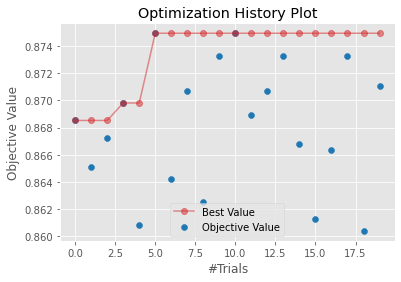

In [45]:
optuna.visualization.matplotlib.plot_optimization_history(cnn_study);

/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_53356/3633289961.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(cnn_study);


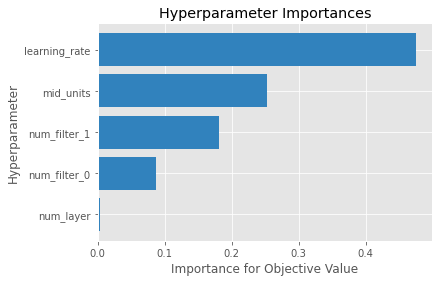

In [46]:
optuna.visualization.matplotlib.plot_param_importances(cnn_study);

/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_53356/3328840784.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(cnn_study);


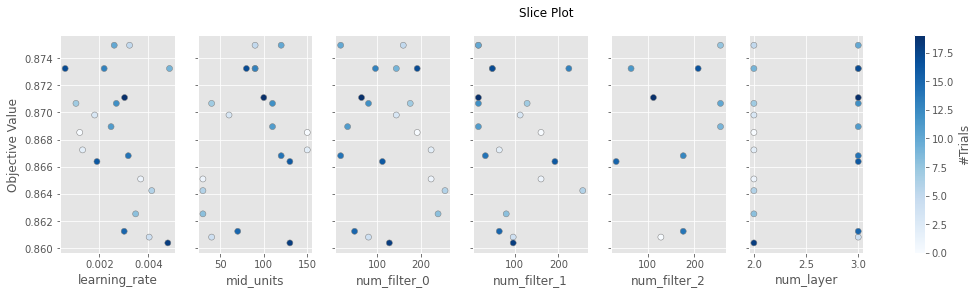

In [47]:
optuna.visualization.matplotlib.plot_slice(cnn_study);

### (3) Training

In [48]:
cnn_acc = []
cnn_pred = np.zeros((test_x.shape[0], 4))
seed = 42
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)

for i, (train_idx, val_idx) in enumerate(skf.split(train_x, train.target)):
    print(f"{i+1} Fold Training.....")
    x_train, y_train = train_x[train_idx], train_y[train_idx]
    x_val, y_val = train_x[val_idx], train_y[val_idx]
    
    cnn = create_model(cnn_study.best_params['num_layer'], cnn_study.best_params['mid_units'], 
                      [cnn_study.best_params[f'num_filter_{i}'] for i in range(cnn_study.best_params['num_layer'])])
    
    # ModelCheckpoint Fold마다 갱신
    mc = ModelCheckpoint(f"model/model_{i+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
    
    # 모델 Complie
    optimizer = Adam(learning_rate=cnn_study.best_params['learning_rate'])
    cnn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
    cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[es,mc], verbose=0)
    
    # 최고 성능 기록 모델
    best = load_model(f"model/model_{i+1}.h5")
    
    val_pred = best.predict(x_val)
    
    val_cls = np.argmax(val_pred, axis=1)
    
    fold_cnn_acc = accuracy_score(np.argmax(y_val, axis=1), val_cls)
    cnn_acc.append(fold_cnn_acc)
    print(f"{i+1} Fold ACC of CNN = {fold_cnn_acc}\n")
    
    fold_pred = best.predict(test_x) / skf.n_splits
    cnn_pred += fold_pred

1 Fold Training.....
1 Fold ACC of CNN = 0.860813704496788

2 Fold Training.....
2 Fold ACC of CNN = 0.8907922912205567

3 Fold Training.....
3 Fold ACC of CNN = 0.8715203426124197

4 Fold Training.....
4 Fold ACC of CNN = 0.8715203426124197

5 Fold Training.....
5 Fold ACC of CNN = 0.8843683083511777



In [49]:
np.mean(cnn_acc)

0.8758029978586723

## 5. Submission

In [ ]:
submission['target'] = np.argmax(cnn_pred, axis = 1)
submission.to_csv('submission/20220313-1.csv', index = False)
submission.target.value_counts()